<div>
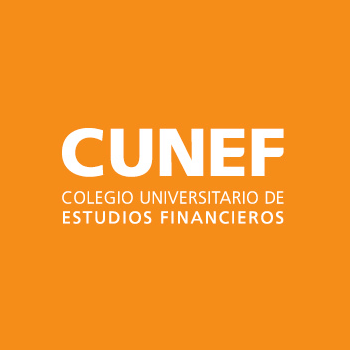
</div>

# **IBEX 35**

En este notebook se mostrará la serie temporal del valor histórico del índice español **IBEX 35** y observaremos cómo afectó ésta frente al COVID-19. 

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías*



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV de los datos históricos del IBEX35 (^IBEX):

- Fuente: https://es.finance.yahoo.com/quote/%5EIBEX/history?period1=742435200&period2=1651968000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [71]:
df=pd.read_csv("^IBEX2.csv")
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index("Date")
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-07-12,2826.800049,2826.800049,2814.600098,2826.399902,2826.396973,0.0
1993-07-13,2826.399902,2843.699951,2820.899902,2843.399902,2843.396973,0.0
1993-07-14,2845.399902,2858.399902,2845.399902,2851.100098,2851.097168,0.0
1993-07-15,2848.699951,2848.699951,2835.000000,2843.699951,2843.697021,0.0
1993-07-16,2843.699951,2848.000000,2818.800049,2830.500000,2830.497070,0.0


Tenemos datos desde el 1993, acortaremos la serie temporal y lo iniciamos desde el 2013 para realizar un análisis más específico.

In [72]:
df=df.iloc[5042:,:]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,8337.900391,8447.599609,8286.700195,8447.599609,8447.590820,280533400.0
2013-01-03,8375.000000,8422.599609,8334.299805,8403.400391,8403.391602,182282600.0
2013-01-04,8411.700195,8447.000000,8386.700195,8435.799805,8435.791016,230118600.0
2013-01-07,8434.299805,8485.599609,8406.299805,8419.000000,8418.991211,289121800.0
2013-01-08,8388.200195,8493.500000,8374.700195,8453.000000,8452.991211,335514800.0
...,...,...,...,...,...,...
2022-08-02,8060.600098,8122.500000,8049.799805,8096.899902,8096.899902,154636100.0
2022-08-03,8092.600098,8161.299805,8066.299805,8142.100098,8142.100098,146693600.0
2022-08-04,8148.000000,8214.400391,8133.899902,8161.100098,8161.100098,135699300.0


Los datos bursátiles que tenemos están a diario. Podríamos descargar el CSV con dichos datos de manera mensual, pero optaremos por hacer una conversión usando la función de remuestreo (resample) que ofrece la librería Pandas.
- Fuente de información: https://stackoverflow.com/questions/28126286/convert-daily-pandas-stock-data-to-monthly-data-using-first-trade-day-of-the-mon

In [73]:
type(df) #comprobamos que en efecto es un DataFrame

pandas.core.frame.DataFrame

In [74]:
ohlc_dict={'Open':'first',
           'High':'max',
           'Low':'min',
           'Close': 'last',
           'Volume': 'sum'}
df=df.resample('MS', # Pondremos MS en vez de M para que se ubique a primeros de mes
               closed='right', 
               label='right').agg(ohlc_dict)
df=df.iloc[:-1,:] #obviamos el mes de septiembre que nos ha calculado en el resample
df

,Open,High,Low,Close,Volume
Date,,,,,
2013-02-01,8337.900391,8755.900391,8159.500000,8229.700195,6.331603e+09
2013-03-01,8225.000000,8400.099609,7895.500000,8187.100098,5.391444e+09
2013-04-01,8135.100098,8670.400391,7797.200195,7920.000000,5.313982e+09
2013-05-01,7917.600098,8524.200195,7716.100098,8419.000000,5.670217e+09
2013-06-01,8393.900391,8669.200195,8216.500000,8320.599609,5.287323e+09
...,...,...,...,...,...
2022-04-01,8145.899902,8621.000000,7287.700195,8503.700195,6.096711e+09
2022-05-01,8536.099609,8877.700195,8344.900391,8584.200195,3.673824e+09
2022-06-01,8516.599609,8992.700195,8134.500000,8747.200195,4.377736e+09


Comprobamos que no haya datos nulos:

In [75]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Las únicas columnas que nos interesan son la de "Date" y la de "Volume", que es la cantidad de un activo concreto en el que se invierte en un periodo de tiempo --> https://www.ig.com/es/glosario-trading/definicion-de-volumen.

Por tanto, procedemos a eliminar el resto de las columnas y nos quedamos con esas:

In [76]:
df_ibex=df.drop(['Open','High','Low','Close'],axis=1)
df_ibex

,Volume
Date,
2013-02-01,6.331603e+09
2013-03-01,5.391444e+09
2013-04-01,5.313982e+09
2013-05-01,5.670217e+09
2013-06-01,5.287323e+09
...,...
2022-04-01,6.096711e+09
2022-05-01,3.673824e+09
2022-06-01,4.377736e+09


Ahora se procede a realizar el análisis exploratorio de los datos.


## *3) EDA*

Para realizar los plots, recurriremos a los que nos ofrece la librería Seaborn:

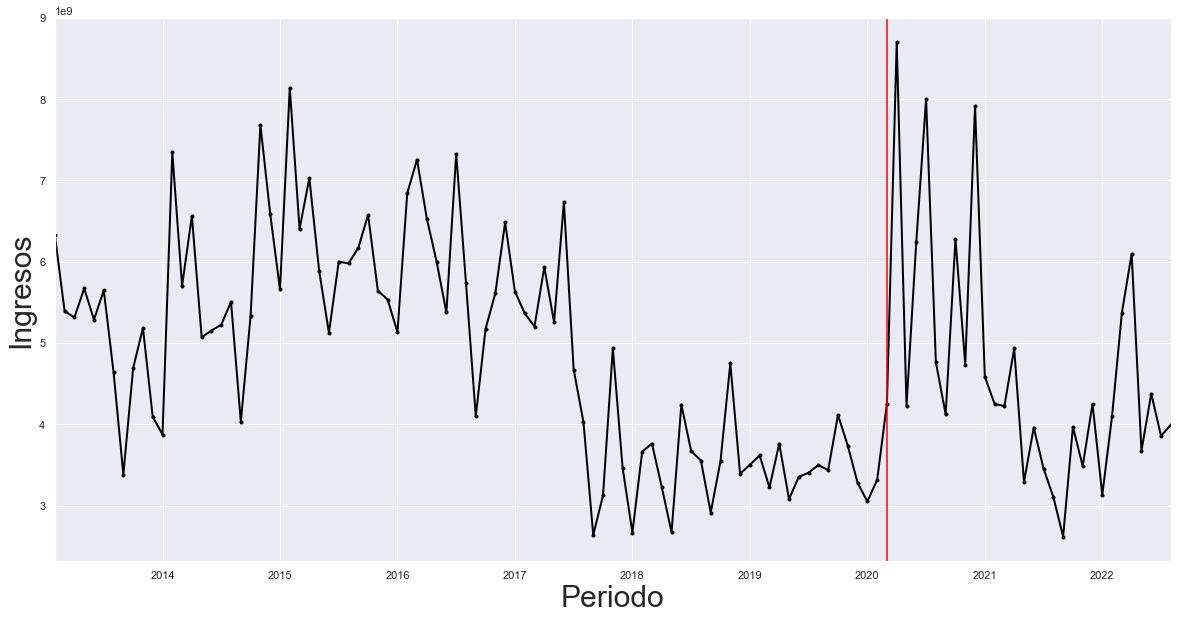

In [77]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_ibex['Volume'].plot(marker='.', color = 'black', linewidth= 2) 
fig.set_ylabel('Ingresos', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

**No se aprecia una tendencia de los índices del IBEX pronunciada hacia ningún lado desde el inicio hasta mediados del 2017, donde hay una tendencia decreciente**. Sin embargo, desde el inicio de la época del COVID el IBEX presenta unos picos de subidas y bajadas muy pronunciados, derivados de decisiones políticas y sucesos que dependen de otras variables, como por ejemplo la vacunación.


A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición

### 3.1) Cálculo de la media y de la varianza

In [78]:
def split_and_summarize(dataframe,column,size,fn):
    ranges=[]
    values=[]
    for i in range(0,len(dataframe),size):
        ranges.append(dataframe[i:i+size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

media=split_and_summarize(df_ibex,'Volume',4,np.mean)
varianza=split_and_summarize(df_ibex,'Volume',4,np.var)

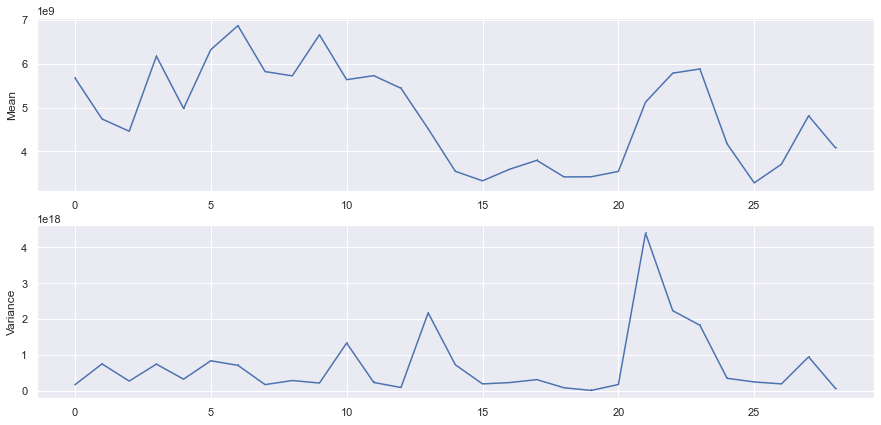

In [79]:
cols = ['media', 'varianza']
df=pd.DataFrame([media,varianza],index=cols)

sns.set(rc={'figure.figsize':(15,7)})
fig,(ax1,ax2)=plt.subplots(2,1)

ax1.plot(media,',-')
ax1.set_ylabel('Mean')

ax2.plot(varianza,',-')
ax2.set_ylabel('Variance')

plt.show()

A simple vista se ve que ni la media ni la varianza tienen unos valores constantes en el tiempo, lo que nos indica que la serie no es estacionaria. Para asegurarnos al 100% realizaremos la prueba de Dickey-Fuller aumentada.

### 3.2) Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [80]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_ibex)

Results of Dickey-Fuller Test:
Test Statistic                  -1.893339
p-value                          0.335201
#Lags Used                      12.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


Se confirma que la serie **no es estacionaria** ya que su p-value >> 0.05, además que el test estadístico es mucho más mayor que los umbrales de significancia.

### 3.3) Gráficas de comportamiento mensual

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

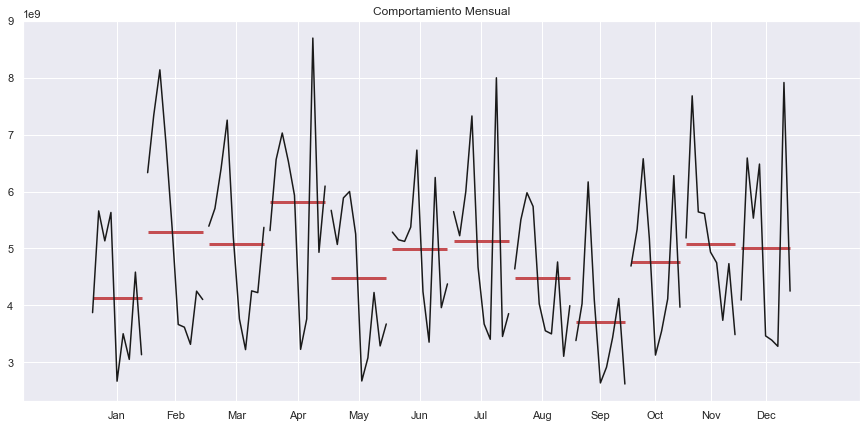

In [81]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_ibex,ax=ax)
ax.set_title('Comportamiento Mensual');

Lo representamos también con box plots:

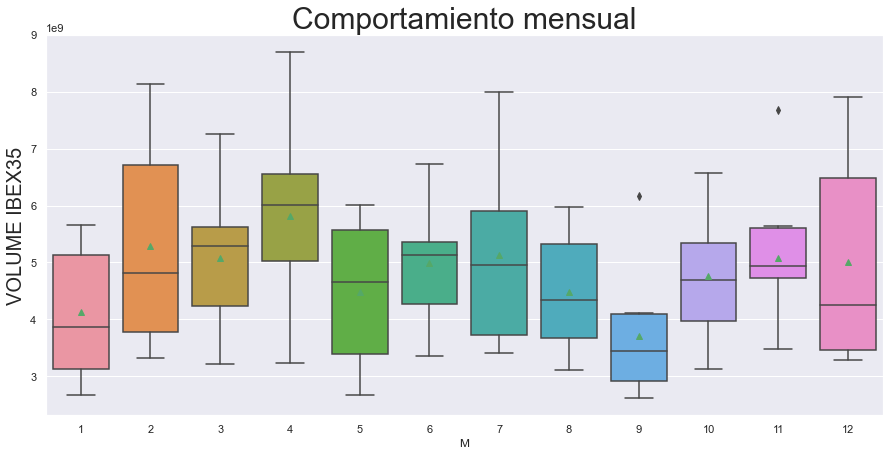

In [82]:
df_ibex['M'] = df_ibex.index.month
sns.boxplot(data = df_ibex, x = 'M', y='Volume', showmeans=True)
ax = plt.gca()
ax.set_ylabel('VOLUME IBEX35', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);


Podemos ver que los meses que menos se invierte en el índice se hallan en enero y septiembre. El resto del año se mantiene más o menos constante. **No parece que tenga componente estacional**.

### 3.4) Descomposición 

Por último, el desglose de la estacionalidad, de la tendencia y de los residuos para analizarlo:

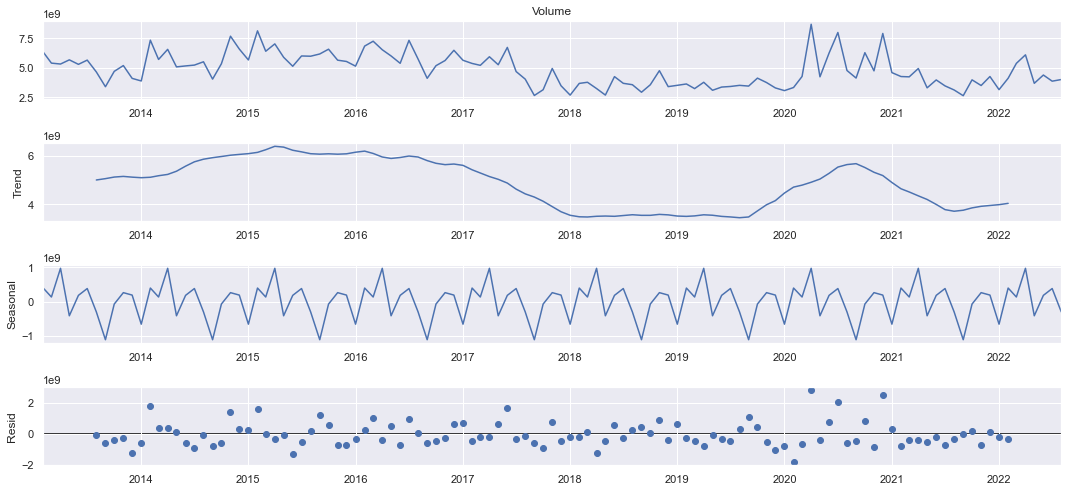

In [83]:
desglose = seasonal_decompose(df_ibex['Volume'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Como análisis, podemos concluir que:
- **La tendencia no es muy clara**, aunque se aprecia una tendencia decreciente en la época COVID.
- **No hay una clara estacionalidad**, aunque se ve que aumenta más la inversión del índice en el mes de marzo.
- Que **la serie temporal no es estacionaria**.

A continuación se procede a la estimación mediante los siguientes modelos.

## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)

A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta agosto del 2022, hay 31 meses para el test_size.



Cantidad de períodos en Train: 85
Cantidad de períodos en Test: 30


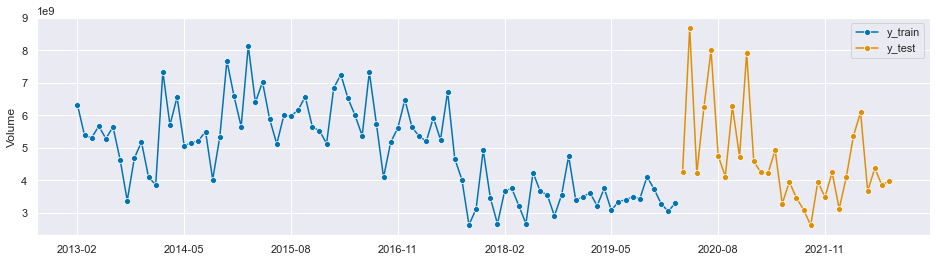

In [84]:
#Train-test
y_train, y_test=temporal_train_test_split(
    y=df_ibex['Volume'].astype('float64').to_period('M'),test_size=30)

#Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:',y_train.shape[0])
print('Cantidad de períodos en Test:',y_test.shape[0])
plt.show()

In [85]:
y_test #observamos los 30 meses testeados

2020-03    4.255071e+09
2020-04    8.696394e+09
2020-05    4.226717e+09
2020-06    6.247014e+09
2020-07    7.998595e+09
2020-08    4.763038e+09
2020-09    4.120969e+09
2020-10    6.279797e+09
2020-11    4.733587e+09
2020-12    7.915763e+09
2021-01    4.584600e+09
2021-02    4.250260e+09
2021-03    4.224012e+09
2021-04    4.932473e+09
2021-05    3.288201e+09
2021-06    3.960182e+09
2021-07    3.454107e+09
2021-08    3.105926e+09
2021-09    2.618904e+09
2021-10    3.967894e+09
2021-11    3.485891e+09
2021-12    4.250970e+09
2022-01    3.133561e+09
2022-02    4.103396e+09
2022-03    5.370831e+09
2022-04    6.096711e+09
2022-05    3.673824e+09
2022-06    4.377736e+09
2022-07    3.855604e+09
2022-08    3.994581e+09
Freq: M, Name: Volume, dtype: float64

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [87]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
ibex_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

In [88]:
ibex_auto_ets.fit(y_train)
ibex_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                 Volume   No. Observations:                   85
Model:                       ETS(MNM)   Log Likelihood               -1851.618
Date:                Wed, 24 Aug 2022   AIC                           3735.237
Time:                        11:59:10   BIC                           3774.319
Sample:                    02-28-2013   HQIC                          3750.957
                         - 02-29-2020   Scale                            0.021
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4373      0.116      3.776      0.000       0.210       0.664
smoothing_seasonal   5.627e-05        nan        nan        nan         nan         nan
initial_level        4.988e+09   1.55e-10   3.22e+19      0.000    4.99e+09    4.99e+09
initial_seasonal.0      0.7521      0.078      9.603      0.000       0.599       0.906
initial_seasonal.1      0.8424      0.092      9.169      0.000       0.662       1.022
initial_seasonal.2      0.9953      0.110      9.024      0.000       0.779       1.211
initial_seasonal.3      0.8293      0.093      8.869      0.000       0.646       1.013
initial_seasonal.4      0.6967      0.078      8.942      0.000       0.544       0.849
initial_seasonal.5      0.8287      0.093      8.954      0.000       0.647       1.010
initial_seasonal.6      0.9016      0.100      9.026      0.000       0.706       1.097
initial_seasonal.7      0.9131      0.098      9.309      0.000       0.721       1.105
initial_seasonal.8      0.8188      0.089      9.169      0.000       0.644       0.994
initial_seasonal.9      0.9354      0.101      9.220      0.000       0.737       1.134
initial_seasonal.10     0.9085      0.095      9.539      0.000       0.722       1.095
initial_seasonal.11     1.0000      0.091     11.030      0.000       0.822       1.178
===================================================================================
Ljung-Box (Q):                       11.91   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.81   Prob(JB):                         0.43
Heteroskedasticity (H):               0.91   Skew:                             0.35
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+18. Standard errors may be unstable.
"""

In [89]:
#step 5: querying predictions
ibex_pred = ibex_auto_ets.predict(fh=list(fh))
ibex_pred.round()

2020-03    3.402753e+09
2020-04    3.503677e+09
2020-05    3.066755e+09
2020-06    3.419812e+09
2020-07    3.376925e+09
2020-08    3.103841e+09
2020-09    2.609397e+09
2020-10    3.105980e+09
2020-11    3.727899e+09
2020-12    3.155148e+09
2021-01    2.817163e+09
2021-02    3.745489e+09
2021-03    3.402753e+09
2021-04    3.503677e+09
2021-05    3.066755e+09
2021-06    3.419812e+09
2021-07    3.376925e+09
2021-08    3.103841e+09
2021-09    2.609397e+09
2021-10    3.105980e+09
2021-11    3.727899e+09
2021-12    3.155148e+09
2022-01    2.817163e+09
2022-02    3.745489e+09
2022-03    3.402753e+09
2022-04    3.503677e+09
2022-05    3.066755e+09
2022-06    3.419812e+09
2022-07    3.376925e+09
2022-08    3.103841e+09
Freq: M, dtype: float64

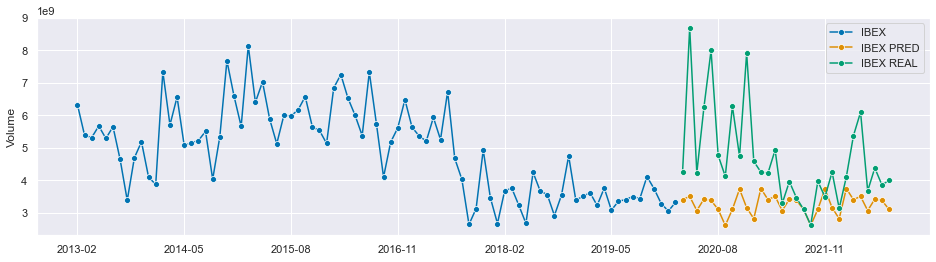

In [91]:
# optional: plotting predictions and past data
plot_series(y_train, ibex_pred, y_test, labels=["IBEX", "IBEX PRED", "IBEX REAL"])
plt.show()

Se hace un zoom al gráfico:

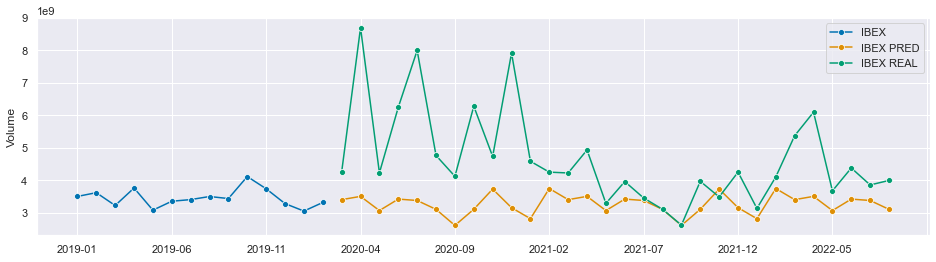

In [93]:
plot_series(y_train["2019":], ibex_pred,y_test, labels=["IBEX", "IBEX PRED", "IBEX REAL"]);

La predicción por ETS, a simple vista, no predice en absoluto el momento COVID, pero a principios del 2021 sí que afina un poco más su precisión. Vamos a calcular el error de las predicciones mediante el RMSE y MAPE. 

In [94]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, ibex_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 1989580589.33


In [95]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, ibex_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 25.37%


### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria en media ni en varianza, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, aplicaremos logaritmo y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

In [98]:
transformer = LogTransformer()
log_df_ibex= transformer.fit_transform(df_ibex['Volume'])
log_df_ibex.tail()

Date
2022-04-01    22.531015
2022-05-01    22.024499
2022-06-01    22.199797
2022-07-01    22.072793
2022-08-01    22.108204
Freq: MS, dtype: float64

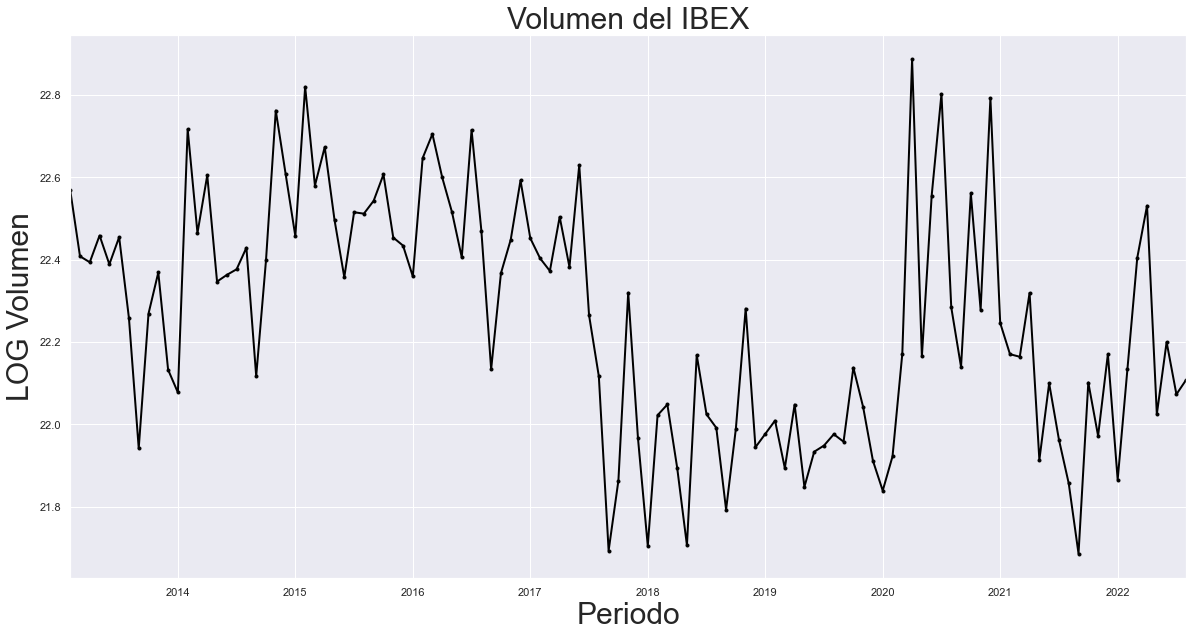

In [99]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_ibex.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Volumen del IBEX', fontsize = 30) 
fig.set_ylabel('LOG Volumen', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y test a la serie transformada en logs:

85 30


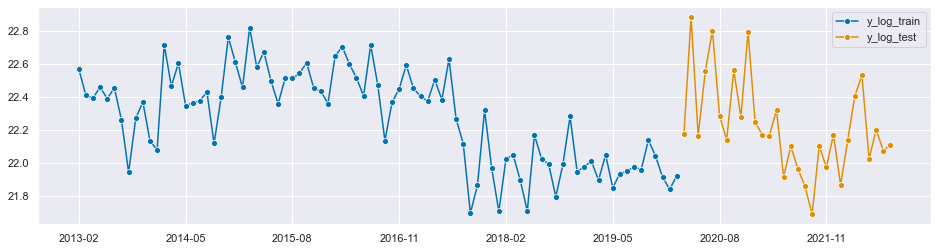

In [100]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_ibex.astype('float64').to_period('M').sort_index(),test_size=30)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [101]:
fh=np.arange(1,y_log_test.shape[0]+1)
ibex_auto_arima=AutoARIMA(sp=12,suppress_warnings=True)

In [102]:
ibex_auto_arima.fit(y_log_train)
ibex_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   85
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                  31.072
Date:                              Wed, 24 Aug 2022   AIC                            -52.145
Time:                                      12:03:41   BIC                            -39.991
Sample:                                           0   HQIC                           -47.259
                                               - 85                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4438      0.103     -4.292      0.000      -0.646      -0.241
ma.L2         -0.2189      0.110     -1.993      0.046      -0.434      -0.004
ar.S.L12       0.9283      0.129      7.218      0.000       0.676       1.180
ma.S.L12      -0.7306      0.278     -2.631      0.009      -1.275      -0.186
sigma2         0.0260      0.005      5.485      0.000       0.017       0.035
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.98
Prob(Q):                              0.87   Prob(JB):                         0.61
Heteroskedasticity (H):               0.82   Skew:                             0.22
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
ibex_log_pred=ibex_auto_arima.predict(fh)
np.exp(ibex_log_pred)

2020-03    3.294830e+09
2020-04    3.445360e+09
2020-05    3.086214e+09
2020-06    3.385184e+09
2020-07    3.321289e+09
2020-08    3.184619e+09
2020-09    2.781872e+09
2020-10    3.187148e+09
2020-11    3.501224e+09
2020-12    3.097920e+09
2021-01    2.904047e+09
2021-02    3.269087e+09
2021-03    3.140959e+09
2021-04    3.230993e+09
2021-05    2.917137e+09
2021-06    3.178577e+09
2021-07    3.122847e+09
2021-08    3.003382e+09
2021-09    2.649125e+09
2021-10    3.005596e+09
2021-11    3.279595e+09
2021-12    2.927407e+09
2022-01    2.756957e+09
2022-02    3.077259e+09
2022-03    2.965141e+09
2022-04    3.043958e+09
2022-05    2.768490e+09
2022-06    2.998092e+09
2022-07    2.949266e+09
2022-08    2.844389e+09
Freq: M, dtype: float64

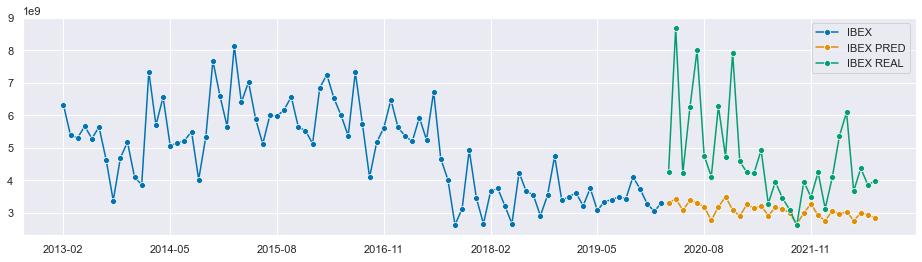

In [104]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(ibex_log_pred), np.exp(y_log_test),
            labels=["IBEX", "IBEX PRED", "IBEX REAL"])
plt.show()

In [105]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(ibex_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 2090110294.61


In [106]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(ibex_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 29.42%


#### Una comparativa entre ETS y ARIMA

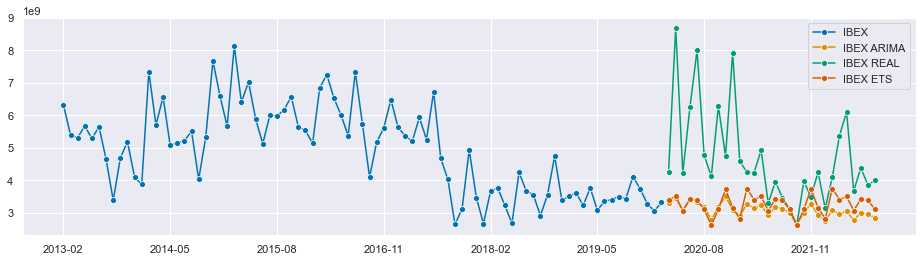

In [107]:
plot_series(np.exp(y_log_train["2013":]), np.exp(ibex_log_pred), np.exp(y_log_test), ibex_pred, 
            labels=["IBEX", "IBEX ARIMA", "IBEX REAL", 'IBEX ETS'])
plt.show()

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [108]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ETS genera un RMSE de: 1989580589.33
El modelo ARIMA genera un RMSE de: 2090110294.61


In [109]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un MAPE de: 25.37%
El modelo ARIMA genera un MAPE de 29.42%


Confirmamos que el modelo ETS, para este caso concreto, predice algo mejor ya que su error es menor.

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [111]:
# Eliminación de la columna 'M' creada anteriormente 
df_ibex=df_ibex.drop(['M'], axis=1)
df_ibex

,Volume
Date,
2013-02-01,6.331603e+09
2013-03-01,5.391444e+09
2013-04-01,5.313982e+09
2013-05-01,5.670217e+09
2013-06-01,5.287323e+09
...,...
2022-04-01,6.096711e+09
2022-05-01,3.673824e+09
2022-06-01,4.377736e+09


In [112]:
prophet_train = df_ibex.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [113]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

85

In [114]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

30

In [115]:
prophet_y_train.tail()

,ds,y
80,2019-10-31,4.114216e+09
81,2019-11-30,3.737937e+09
82,2019-12-31,3.281100e+09
83,2020-01-31,3.051456e+09
84,2020-02-29,3.315812e+09


In [116]:
prophet_y_test.head()

,ds,y
0,2020-03-31,4.255071e+09
1,2020-04-30,8.696394e+09
2,2020-05-31,4.226717e+09
3,2020-06-30,6.247014e+09
4,2020-07-31,7.998595e+09


In [117]:
m = Prophet()
m.fit(prophet_y_train)

12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing


In [118]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

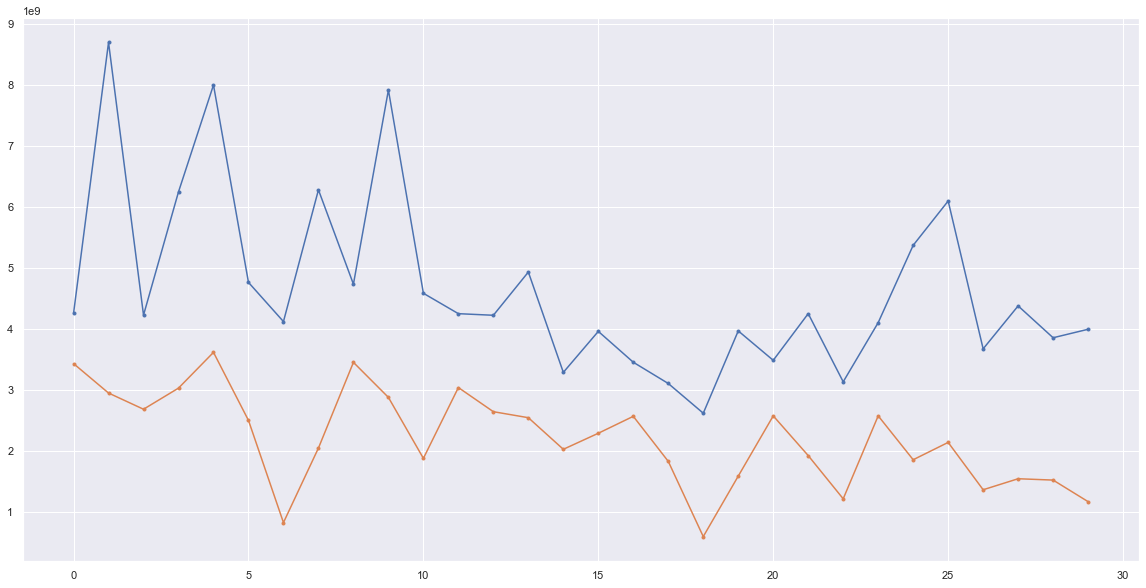

In [119]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[85:, 'yhat']), '.-', label='Predicition')
plt.show()

In [125]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[85:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 51.33%


In [122]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[85:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 2751456414.21


In [123]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
110,2022-04-30,2.140343e+09,1.060846e+09,3.069306e+09
111,2022-05-31,1.364261e+09,4.370263e+08,2.413556e+09
112,2022-06-30,1.544806e+09,6.071679e+08,2.523462e+09
113,2022-07-31,1.522712e+09,4.687604e+08,2.507668e+09
114,2022-08-31,1.169263e+09,1.657593e+08,2.127327e+09


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [124]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 1989580589.33
El modelo ARIMA genera un RMSE de: 2090110294.61
El modelo Prophet genera un RMSE de: 2751456414.21


2) MAPE (Error porcentual)

In [133]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 25.37%
El modelo ARIMA genera un MAPE de 29.42%
El modelo Prophet genera un MAPE de 51.33%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es la ETS**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da, aunque se considera que es un error un poco elevado.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo intervenido hasta finales de año, es decir, hasta diciembre del 2022. 

In [126]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 6)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_ibex.astype('float64').to_period('M')
autoets_predict.fit(y)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [127]:
print(autoets_predict.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  115
Model:                       ETS(MNM)   Log Likelihood               -2532.904
Date:                Wed, 24 Aug 2022   AIC                           5097.808
Time:                        12:08:05   BIC                           5141.726
Sample:                    02-28-2013   HQIC                          5115.634
                         - 08-31-2022   Scale                            0.036
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4531      0.093      4.883      0.000       0.271       0.635
smoothing_seasonal   5.469e-05        nan        nan        nan         nan         nan
initial_level   

In [130]:
# Predicción del desempleo para los próximos 6 meses:
ibexnew_pred = autoets_predict.predict(fh=list(fh))
ibexnew_pred.round()

,Volume
2022-09,3.149020e+09
2022-10,3.943284e+09
2022-11,4.378688e+09
2022-12,4.251466e+09
2023-01,3.409271e+09


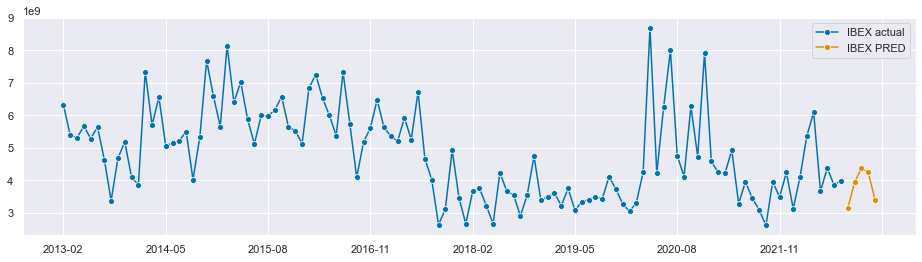

In [134]:
# Representamos gráficamente:
plot_series(y, ibexnew_pred, labels=["IBEX actual", "IBEX PRED"])
plt.show()